In [1]:
import pandas as pd
import numpy as np
from itertools import product
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import RandomizedSearchCV
import random


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/sbermarket-internship-competition/sample_submission.csv
/kaggle/input/sbermarket-internship-competition/train.csv


In [2]:
train = pd.read_csv('/kaggle/input/sbermarket-internship-competition/train.csv')
test = pd.read_csv('/kaggle/input/sbermarket-internship-competition/sample_submission.csv')
train['order_completed_at'] = pd.to_datetime(train['order_completed_at'])
train.head()

,user_id,order_completed_at,cart
0,2,2015-03-22 09:25:46,399
1,2,2015-03-22 09:25:46,14
2,2,2015-03-22 09:25:46,198
3,2,2015-03-22 09:25:46,88
4,2,2015-03-22 09:25:46,157


**EDA**

In [3]:
train.describe(include='all')

,user_id,order_completed_at,cart
count,3.123064e+06,3123064,3.123064e+06
mean,7.253373e+03,2020-04-09 01:17:00.182836992,2.273235e+02
min,0.000000e+00,2015-03-22 09:25:46,0.000000e+00
25%,2.884000e+03,2020-02-03 06:03:43,4.200000e+01
50%,6.055000e+03,2020-05-19 06:35:20,1.460000e+02
75%,1.117200e+04,2020-07-14 04:50:22,3.990000e+02
max,1.999900e+04,2020-09-03 23:45:45,8.800000e+02
std,5.337838e+03,NaN,2.112867e+02


In [4]:
print(train.shape)
print(train.isna().sum().sum())

(3123064, 3)
0


In [5]:
train['user_id'].value_counts()

user_id
380      3508
105      2833
84       2610
3918     2566
1156     2357
         ... 
9614        3
8990        3
3844        3
19825       3
19841       3
Name: count, Length: 20000, dtype: int64

In [6]:
categs = train['cart'].value_counts()
categs.head()

cart
57     108877
14      93957
61      91543
398     81694
23      71837
Name: count, dtype: int64

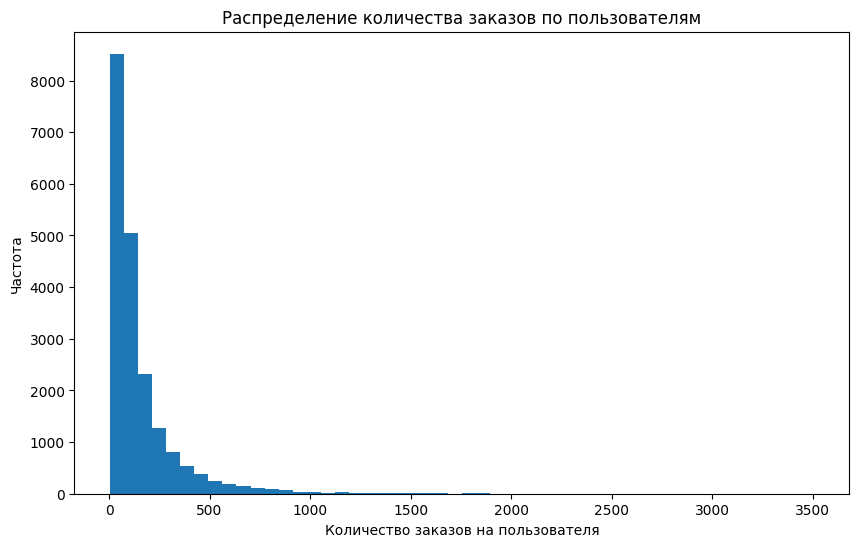

In [29]:
import matplotlib.pyplot as plt

order_counts = train['user_id'].value_counts()
plt.figure(figsize=(10, 6))
plt.hist(order_counts, bins=50)
plt.xlabel('Количество заказов на пользователя')
plt.ylabel('Частота')
plt.title('Распределение количества заказов по пользователям')
plt.show()


Добавление искуственных данных

In [7]:
train = train.sort_values(by=['user_id', 'order_completed_at'])

train['target'] = 1

new_rows = []

for user_id, user_orders in train.groupby('user_id'):
    
    user_orders_by_date = user_orders.groupby('order_completed_at')
    
    all_previous_items = set()
    
    for order_date, order_group in user_orders_by_date:
        current_order_items = set(order_group['cart'])
        
        not_ordered_items = all_previous_items - current_order_items

        num_items_to_add = min(len(not_ordered_items), len(current_order_items))

        items_to_add = random.sample(not_ordered_items, num_items_to_add)

        for item in items_to_add:
            new_row = {
                'user_id': user_id,
                'cart': item,  
                'order_completed_at': order_date,
                'target': 0,
            }
            new_rows.append(new_row)

        all_previous_items.update(current_order_items)


new_data = pd.DataFrame(new_rows)

train_with_zeros = pd.concat([train, new_data], ignore_index=True)

print(train_with_zeros.head())

/tmp/ipykernel_30/74258621.py:20: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  items_to_add = random.sample(not_ordered_items, num_items_to_add)


   user_id  order_completed_at  cart  target
0        0 2020-07-19 09:59:17    20       1
1        0 2020-07-19 09:59:17    82       1
2        0 2020-07-19 09:59:17   441       1
3        0 2020-07-19 09:59:17    57       1
4        0 2020-07-19 09:59:17    14       1


In [13]:
print(train_with_zeros.shape)
print(train_with_zeros.isna().sum().sum())


(5708975, 4)
0


**Train Validation Split**

In [8]:
cutoff_date = '2020-07-14'

# Разделим на тренировочную и валидационную выборки, используя дату третьего квартиля 
train_set = train_with_zeros[train_with_zeros['order_completed_at'] < cutoff_date].copy()
val_set = train_with_zeros[train_with_zeros['order_completed_at'] >= cutoff_date].copy()
print(f"Количество записей в train_set: {len(train_set)}")
print(f"Количество записей в val_set: {len(val_set)}")
print(f"Количество записей в test: {len(test)}")

Количество записей в train_set: 4214901
Количество записей в val_set: 1494074
Количество записей в test: 790449


**Feature Engineering**

In [15]:
test[['user_id', 'cart']] = test['id'].str.split(';', expand=True)
test['user_id'] = test['user_id'].astype(int)

print('Пользователей в train_set: ', train_set['user_id'].nunique())
print('Пользователей в val_set: ', val_set['user_id'].nunique())
print('Пользователей в test: ', test['user_id'].nunique())


val_users_not_in_train = set(val_set['user_id']) - set(train_set['user_id'])
print(f"Количество пользователей в val_set, но отсутствующих в train_set: {len(val_users_not_in_train)}")

test_users_not_in_train = set(test['user_id']) - set(train_set['user_id'])
print(f"Количество пользователей в test, но отсутствующих в train_set: {len(test_users_not_in_train)}")


Пользователей в train_set:  18161
Пользователей в val_set:  16160
Пользователей в test:  13036
Количество пользователей в val_set, но отсутствующих в train_set: 1839
Количество пользователей в test, но отсутствующих в train_set: 1443


Средннее количество позиций в заказах пользователя

In [26]:
order_sizes = train_set.groupby(['user_id', 'order_completed_at'])['cart'].nunique().reset_index(name='order_size')
avg_order_size = order_sizes.groupby('user_id')['order_size'].mean().reset_index(name='avg_order_size')

train_set = train_set.merge(avg_order_size, on='user_id', how='left')
val_set = val_set.merge(avg_order_size, on='user_id', how='left')

# train_set.head()
val_set.head()

,user_id,order_completed_at,cart,target,avg_order_size
0,0,2020-07-19 09:59:17,20,1,NaN
1,0,2020-07-19 09:59:17,82,1,NaN
2,0,2020-07-19 09:59:17,441,1,NaN
3,0,2020-07-19 09:59:17,57,1,NaN
4,0,2020-07-19 09:59:17,14,1,NaN


In [27]:
test = test.merge(avg_order_size, on='user_id', how='left')
test['avg_order_size'].isna().sum()

53284

**Количество уникальных категорий, которые покупал каждый пользователь**

In [28]:
user_category_counts = train_set.groupby('user_id')['cart'].nunique().reset_index()
user_category_counts.columns = ['user_id', 'unique_category_count']

train_set = train_set.merge(user_category_counts, on='user_id', how='left')
val_set = val_set.merge(user_category_counts, on='user_id', how='left')
train_set.head()

,user_id,order_completed_at,cart,target,avg_order_size,unique_category_count
0,1,2019-05-08 16:09:41,55,1,5.875,15
1,1,2020-01-17 14:44:23,82,1,5.875,15
2,1,2020-01-17 14:44:23,798,1,5.875,15
3,1,2020-01-17 14:44:23,86,1,5.875,15
4,1,2020-01-17 14:44:23,421,1,5.875,15


In [11]:
test = test.merge(user_category_counts, on='user_id', how='left')
test['unique_category_count'].isna().sum()
# test.head()

53284

Последняя дата покупки для каждой пары (user_id, category_id)

In [12]:
last_order_date = train_set.groupby(['user_id', 'cart'])['order_completed_at'].max().reset_index()
last_order_date.columns = ['user_id', 'cart', 'last_order_date']

train_set = train_set.merge(last_order_date, on=['user_id', 'cart'], how='left')
val_set = val_set.merge(last_order_date, on=['user_id', 'cart'], how='left')
train_set.head()

,user_id,order_completed_at,cart,target,avg_order_size,unique_category_count,last_order_date
0,1,2019-05-08 16:09:41,55,1,5.875,15,2020-05-24 11:13:59
1,1,2020-01-17 14:44:23,82,1,5.875,15,2020-05-24 11:13:59
2,1,2020-01-17 14:44:23,798,1,5.875,15,2020-05-24 11:13:59
3,1,2020-01-17 14:44:23,86,1,5.875,15,2020-04-14 01:31:20
4,1,2020-01-17 14:44:23,421,1,5.875,15,2020-03-29 13:26:49


In [13]:
last_order_date['cart'] = last_order_date['cart'].astype(str)
test['cart'] = test['cart'].astype(str)
test = test.merge(last_order_date, on=['user_id', 'cart'], how='left')
test['last_order_date'].isna().sum()

179800

In [14]:
# Заполнение пустых значений


default_values = {
    'avg_order_size': 0,              
    'unique_category_count': 0,       
    'last_order_date': pd.Timestamp('1900-01-01')  # Условная дата для отсутствия заказов у новых пользователей
}


val_set.fillna(default_values, inplace=True)
test.fillna(default_values, inplace=True)

In [15]:
train_set['target'].value_counts()

target
1    2341288
0    1873613
Name: count, dtype: int64

In [16]:
# train_set['target'] = 1

X_train = train_set.drop(columns=['target', 'order_completed_at'])
y_train = train_set['target']
X_val = val_set.drop(columns=['target', 'order_completed_at'])
y_val = val_set['target']

print(X_train.head())
print(X_val.head())

   user_id  cart  avg_order_size  unique_category_count     last_order_date
0        1    55           5.875                     15 2020-05-24 11:13:59
1        1    82           5.875                     15 2020-05-24 11:13:59
2        1   798           5.875                     15 2020-05-24 11:13:59
3        1    86           5.875                     15 2020-04-14 01:31:20
4        1   421           5.875                     15 2020-03-29 13:26:49
   user_id  cart  avg_order_size  unique_category_count last_order_date
0        0    20             0.0                    0.0      1900-01-01
1        0    82             0.0                    0.0      1900-01-01
2        0   441             0.0                    0.0      1900-01-01
3        0    57             0.0                    0.0      1900-01-01
4        0    14             0.0                    0.0      1900-01-01


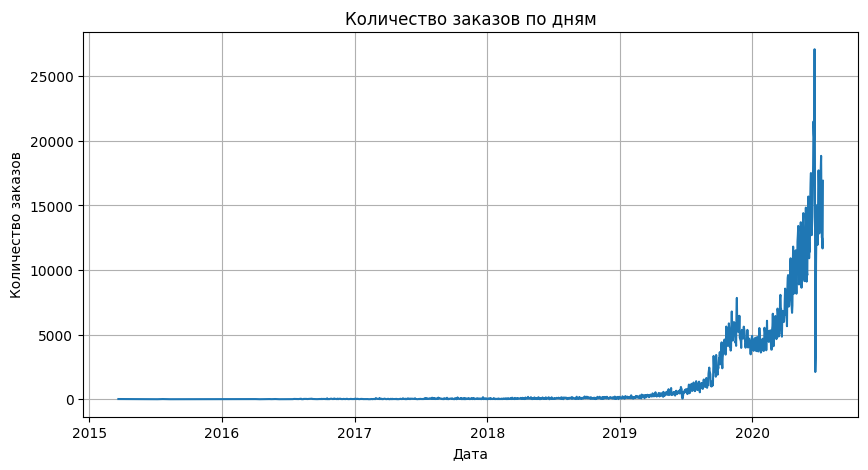

In [9]:
daily_orders = train.groupby(train_set['order_completed_at'].dt.date)['cart'].count()

# Построение линейного графика
plt.figure(figsize=(10, 5))
daily_orders.plot(kind='line')
plt.title('Количество заказов по дням')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.grid(True)
plt.show()

Pipeline

In [17]:
from sklearn.preprocessing import OrdinalEncoder

numeric_features = ['avg_order_size', 'unique_category_count']
categorical_features = ['user_id', 'cart']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())  
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinalencoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])


preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)


In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
import lightgbm as lgb
import xgboost as xgb


models = {
    "RandomForest": RandomForestClassifier(random_state=42, class_weight='balanced'),
    "LightGBM": lgb.LGBMClassifier(random_state=42, class_weight='balanced'),
    "XGBoost": xgb.XGBClassifier(random_state=42, scale_pos_weight=y_train.value_counts()[0] / y_train.value_counts()[1])
}


def evaluate_model(model, X_train, y_train, X_val, y_val, preprocessor):
    
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    
    
    pipeline.fit(X_train, y_train)
    
    
    y_train_pred = pipeline.predict(X_train)
    print(f"Training Classification Report for {model.__class__.__name__}:")
    print(classification_report(y_train, y_train_pred))
    
    
    y_val_pred = pipeline.predict(X_val)
    print(f"Validation Classification Report for {model.__class__.__name__}:")
    print(classification_report(y_val, y_val_pred))


for model_name, model in models.items():
    print(f"\nEvaluating model: {model_name}")
    evaluate_model(model, X_train, y_train, X_val, y_val, preprocessor)



Evaluating model: RandomForest
Training Classification Report for RandomForestClassifier:
              precision    recall  f1-score   support

           0       0.68      0.77      0.72   1873613
           1       0.79      0.70      0.75   2341288

    accuracy                           0.73   4214901
   macro avg       0.73      0.74      0.73   4214901
weighted avg       0.74      0.73      0.73   4214901

Validation Classification Report for RandomForestClassifier:
              precision    recall  f1-score   support

           0       0.64      0.41      0.50    712298
           1       0.60      0.79      0.68    781776

    accuracy                           0.61   1494074
   macro avg       0.62      0.60      0.59   1494074
weighted avg       0.62      0.61      0.59   1494074


Evaluating model: LightGBM
[LightGBM] [Info] Number of positive: 2341288, number of negative: 1873613
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.047

In [19]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
import lightgbm as lgb


param_dist = {
    'classifier__num_leaves': [31, 50, 100],  # Количество листьев в дереве
    'classifier__max_depth': [-1, 5, 10, 20],  # Максимальная глубина деревьев
    'classifier__learning_rate': [0.01, 0.05, 0.1, 0.2],  # Скорость обучения
    'classifier__n_estimators': [50, 100, 200],  # Количество деревьев
    'classifier__subsample': [0.6, 0.8, 1.0],  # Часть данных для каждого дерева
    'classifier__colsample_bytree': [0.6, 0.8, 1.0],  # Часть признаков для каждого дерева
}


pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),  
    ('classifier', lgb.LGBMClassifier(random_state=42, class_weight='balanced'))
])


random_search = RandomizedSearchCV(
    pipeline, 
    param_distributions=param_dist, 
    n_iter=20,                # Количество итераций поиска
    scoring='f1_weighted',    
    cv=3,                     
    random_state=42,          
    n_jobs=-1,                
    verbose=2                 
)


random_search.fit(X_train, y_train)


best_model = random_search.best_estimator_


print("Лучшие параметры:", random_search.best_params_)


y_train_pred = best_model.predict(X_train)
print("Training Classification Report:")
print(classification_report(y_train, y_train_pred))

y_val_pred = best_model.predict(X_val)
print("Validation Classification Report:")
print(classification_report(y_val, y_val_pred))


Fitting 3 folds for each of 20 candidates, totalling 60 fits
[LightGBM] [Info] Number of positive: 1560858, number of negative: 1249076
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.041115 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 934
[LightGBM] [Info] Number of data points in the train set: 2809934, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[CV] END classifier__colsample_bytree=0.8, classifier__learning_rate=0.05, classifier__max_depth=10, classifier__n_estimators=50, classifier__num_leaves=50, classifier__subsample=0.8; total time=  17.7s
[LightGBM] [Info] Number of positive: 1560859, number of negative: 1249075
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.041350 seco

In [23]:
test.head()

,id,target,user_id,cart,avg_order_size,unique_category_count,last_order_date
0,0;133,0,0,133,0.0,0.0,1900-01-01
1,0;5,1,0,5,0.0,0.0,1900-01-01
2,0;10,0,0,10,0.0,0.0,1900-01-01
3,0;396,1,0,396,0.0,0.0,1900-01-01
4,0;14,0,0,14,0.0,0.0,1900-01-01


In [35]:
# ids = test['id']
# test = test.drop(columns=['id', 'target'])

# X_test = preprocessor.transform(test)
y_test_pred = best_model.predict(test)

submission_df = pd.DataFrame({
    'id': ids,
    'target': y_test_pred
})

print(submission_df.head())
# print(test.head())
# print(X_val.head())

      id  target
0  0;133       1
1    0;5       1
2   0;10       1
3  0;396       1
4   0;14       1


In [36]:
submission_df.to_csv('submission.csv', index=False)

In [37]:
from shutil import move
move('submission.csv', '/kaggle/working/submission.csv')

'/kaggle/working/submission.csv'